## Setup

In [1]:
# Import necessary libraries

import tensorflow as tf
import numpy as np
import cv2
import os
import uuid
import random
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall

In [2]:
# Verify GPU availability

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    for device in gpu_devices:
        print(f"GPU found: {device.name}")
else:
    print("No GPU found.")

GPU found: /physical_device:GPU:0


2024-05-12 23:36:07.166548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-12 23:36:07.180489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-12 23:36:07.180524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
#Create paths and directories

base_dir = 'model_data'
sub_dirs = ['user_positive_images', 'preloaded_negative_images', 'user_anchor_images', 'input_image']
for sub_dir in sub_dirs:
    path = os.path.join(base_dir, sub_dir)
    os.makedirs(path, exist_ok=True)

In [4]:
# Extract dataset from downloaded website file

os.system('tar -xf lfw.tgz')

0

In [5]:
# Relocate LFW dataset images to 'preloaded_negative_images folder' for training

for folder in os.listdir('lfw'):
    for image in os.listdir(os.path.join('lfw', folder)):
        source_path = os.path.join('lfw', folder, image)
        target_path = os.path.join(base_dir, 'preloaded_negative_images', image)
        os.rename(source_path, target_path)

## Collect positive and anchor pictures from user

In [6]:
# Function to use webcam and openCV to open the webcam and capture pictures of anchor and positive
# Capture anchor pictures first using 'a' key
# Total of 500 captured

def capture_images(image_type, sub_dir):
    cap_device = cv2.VideoCapture(-1)
    cap_device.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'))
    while cap_device.isOpened():
        ret, frame = cap_device.read()
        frame_cropped = frame[120:520, 200:600]

        if cv2.waitKey(1) & 0xFF == ord(image_type[0]):
            img_path = os.path.join(base_dir, sub_dir, f'{uuid.uuid4()}.jpg')
            cv2.imwrite(img_path, frame_cropped)

        cv2.imshow("Capture", frame_cropped)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap_device.release()
    cv2.destroyAllWindows()

In [7]:
# Capture anchor and positive images, using 'a' key for anchor images, and 'p' key for positive images
capture_images('anchor', 'user_anchor_images')
capture_images('positive', 'user_positive_images')

## Prepare and Preprocess Images - scale and resize appropriately

In [8]:
# Prepare dataset
def prepare_datasets(path_pattern, sample_size):
    files = tf.data.Dataset.list_files(path_pattern).take(sample_size)
    return files

# Preprocess images
def preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, [100, 100])
    return image / 255.0

# Pair datasets for Siamese network training
def pair_datasets(anchor, positive, label):
    return (preprocess_image(anchor), preprocess_image(positive)), label


anchor_data = prepare_datasets(f'{base_dir}/user_anchor_images/*.jpg', 100)
positive_data = prepare_datasets(f'{base_dir}/user_positive_images/*.jpg', 100)
negative_data = prepare_datasets(f'{base_dir}/preloaded_negative_images/*.jpg', 100)

positive_pairs = tf.data.Dataset.zip((anchor_data, positive_data, tf.data.Dataset.from_tensors(1).repeat()))
negative_pairs = tf.data.Dataset.zip((anchor_data, negative_data, tf.data.Dataset.from_tensors(0).repeat()))
full_dataset = positive_pairs.concatenate(negative_pairs)

samples = full_dataset.as_numpy_iterator()
one_sample = samples.next()
print(one_sample)

(b'model_data/user_anchor_images/ab601420-10bd-11ef-b322-59bd0e4a1903.jpg', b'model_data/user_positive_images/c289f551-10bd-11ef-b322-59bd0e4a1903.jpg', 1)


2024-05-12 23:37:01.963398: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 23:37:01.966663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-12 23:37:01.966739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-12 23:37:01.966774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

## Create train and test model

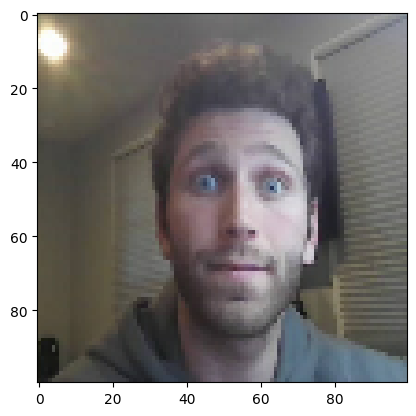

In [9]:
# Build Train and Test Partition
def preprocess_twin(input_img, validation_img, label):
    return(preprocess_image(input_img), preprocess_image(validation_img), label)

res = preprocess_twin(*one_sample)
plt.imshow(res[1])

# Build dataloader pipeline
full_dataset = full_dataset.map(preprocess_twin)
full_dataset = full_dataset.cache()
full_dataset = full_dataset.shuffle(buffer_size=1024)

# Training partition
train_data = full_dataset.take(round(len(full_dataset)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = full_dataset.skip(round(len(full_dataset)*.7))
test_data = test_data.take(round(len(full_dataset)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Embedded Layer Model Building

In [10]:
#Build Embedded Layer

def embedded_model():
    
    inp = Input(shape=(100,100,3), name='input_image')
    
     # first layer
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    #second layer
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    #third layer
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    #fourth layer
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

embedded_model = embedded_model()
embedded_model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [11]:
# Define the distance layer for the Siamese network
class EmbeddingDistance(Layer):
    """
    This class calculates the L1 distance between embedding vectors.
    It extends TensorFlow's Layer class for integration in a model.
    """
    def __init__(self, **kwargs):
        super(EmbeddingDistance, self).__init__(**kwargs)
    
    def call(self, emb1, emb2):
        # Compute absolute difference between embeddings
        return tf.math.abs(emb1 - emb2)

In [12]:
# Construct the Siamese Neural Network
def build_siamese_network():
    """
    Function to build a Siamese network that compares two input images.
    Returns a compiled model.
    """
    # Define the inputs for the two images to compare
    anchor_input = Input(name='anchor_img', shape=(100, 100, 3))
    compare_input = Input(name='compare_img', shape=(100, 100, 3))
    
    # Instantiate the distance layer
    distance_layer = EmbeddingDistance(name='compare_layer')
    # Apply the embedding model to both inputs
    distances = distance_layer(embedded_model(anchor_input), embedded_model(compare_input))
    
    # Output layer that performs classification
    output_layer = Dense(1, activation='sigmoid')(distances)
    
    # Create the Siamese network model
    siamese_network = Model(inputs=[anchor_input, compare_input], outputs=output_layer, name='Siamese_Network')
    return siamese_network

# Initialize the Siamese network model and print the summary
siamese_network_instance = build_siamese_network()
siamese_network_instance.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_img (InputLayer)        [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 compare_img (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['anchor_img[0][0]',             
                                                                  'compare_img[0][0]

## Train Model

In [15]:
# Setup optimizer and loss function for model training
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_function = tf.keras.losses.BinaryCrossentropy()

# Define the training operation
@tf.function
def execute_training_step(batch_data):
    """
    Performs a single training step including forward pass, loss calculation,
    and backward pass for gradient updates.
    """
    with tf.GradientTape() as tape:
        # Unpack the data
        inputs, labels = batch_data[:2], batch_data[2]
        
        # Perform a forward pass through the network
        predictions = siamese_network_instance(inputs, training=True)
        
        # Compute the loss value for this batch
        loss_value = loss_function(labels, predictions)

    # Retrieve the gradients of the trainable variables with respect to the loss
    gradients = tape.gradient(loss_value, siamese_network_instance.trainable_variables)
    
    # Apply the gradients to the optimizer
    optimizer.apply_gradients(zip(gradients, siamese_network_instance.trainable_variables))
    
    # Return the loss value as a tensor
    return loss_value

def run_training_loop(training_data, number_of_epochs):
    """
    Runs the training loop over the specified number of epochs.
    """
    # Iterate through epochs
    for epoch in range(1, number_of_epochs + 1):
        print(f'\n Epoch {epoch}/{number_of_epochs}')
        progress_bar = tf.keras.utils.Progbar(target=len(training_data))
        
        # Metrics to monitor
        recall_metric = tf.keras.metrics.Recall()
        precision_metric = tf.keras.metrics.Precision()
        
        # Iterate over the batches of the dataset
        for index, batch in enumerate(training_data):
            # Perform a training step
            loss = execute_training_step(batch)
            prediction_results = siamese_network_instance.predict(batch[:2])
            
            # Update metrics with current batch results
            recall_metric.update_state(batch[2], prediction_results)
            precision_metric.update_state(batch[2], prediction_results)
            
            # Update progress bar
            progress_bar.update(index + 1)
        
        # Output metrics at the end of the epoch
        print(f"Loss: {loss}, Recall: {recall_metric.result()}, Precision: {precision_metric.result()}")

# Initialize and run the training loop
run_training_loop(train_data, 50)



 Epoch 1/50


2024-05-12 23:40:48.941493: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2024-05-12 23:40:51.583049: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


9/9 [==============================] - 8s 419ms/step
Loss: 0.30855730175971985, Recall: 1.0, Precision: 0.9610389471054077

 Epoch 2/50
9/9 [==============================] - 3s 336ms/step
Loss: 0.1397264152765274, Recall: 1.0, Precision: 1.0

 Epoch 3/50
9/9 [==============================] - 3s 334ms/step
Loss: 0.014603731222450733, Recall: 1.0, Precision: 1.0

 Epoch 4/50
9/9 [==============================] - 3s 333ms/step
Loss: 0.0007739571738056839, Recall: 1.0, Precision: 1.0

 Epoch 5/50
9/9 [==============================] - 3s 335ms/step
Loss: 0.00019405809871386737, Recall: 1.0, Precision: 1.0

 Epoch 6/50
9/9 [==============================] - 3s 334ms/step
Loss: 4.186892692814581e-05, Recall: 1.0, Precision: 1.0

 Epoch 7/50
9/9 [==============================] - 3s 337ms/step
Loss: 2.083718754875008e-05, Recall: 1.0, Precision: 1.0

 Epoch 8/50
9/9 [==============================] - 3s 344ms/step
Loss: 1.5109936612134334e-05, Recall: 1.0, Precision: 1.0

 Epoch 9/50
9/9 [

## Evaluate model and visualize results

Predictions: [[9.9999928e-01]
 [9.9999917e-01]
 [9.9999988e-01]
 [9.9999917e-01]
 [4.1419515e-08]
 [1.2347274e-06]
 [9.9999976e-01]
 [5.3838647e-07]
 [1.0546485e-07]
 [1.2452658e-07]
 [4.0509923e-07]
 [9.9998653e-01]
 [9.9999964e-01]
 [9.9999988e-01]
 [9.9999869e-01]
 [2.3121292e-08]]


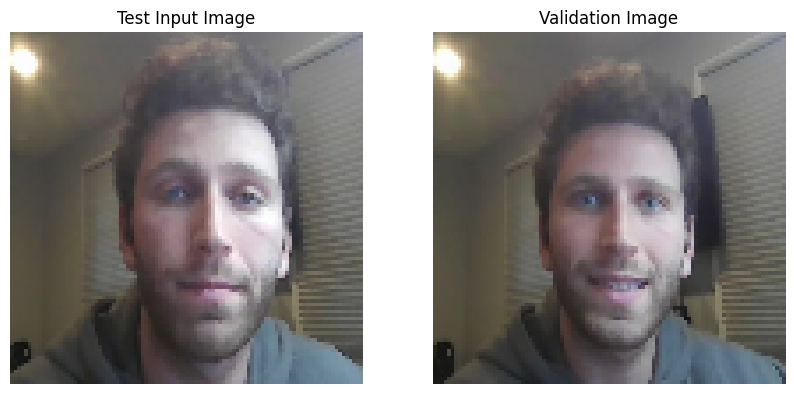

Model saved at siameseModel.h5
Loaded model details:
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_img (InputLayer)        [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 compare_img (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['anchor_img[0][0]',             
                               

In [19]:
# Evaluation and Visualization of the Siamese Model

# Fetch a single batch of test data
test_batch = test_data.as_numpy_iterator().next()
test_input, test_val, y_true = test_batch

# Make predictions using the Siamese model
predictions = siamese_network_instance.predict([test_input, test_val])
print("Predictions:", predictions)

# Visualizing the input and validation images from the test batch
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 8))  # Create a figure with a 1x2 grid of Axes

# Display the first test input image
axes[0].imshow(test_input[0])
axes[0].set_title("Test Input Image")
axes[0].axis('off')  # Hide axes ticks

# Display the first validation image
axes[1].imshow(test_val[0])
axes[1].set_title("Validation Image")
axes[1].axis('off')

plt.show()  # Display the figure

# Model Persistence: Save and Load Operations

# Save the trained Siamese model
model_path = 'siameseModel.h5'
siamese_network_instance.save(model_path)
print(f"Model saved at {model_path}")

# Load the saved model to verify it loads correctly and compile it with the custom objects used
from tensorflow.keras.models import load_model

loaded_model = load_model(model_path, custom_objects={'EmbeddingDistance': EmbeddingDistance})
print("Loaded model details:")
loaded_model.summary()

# Optionally, make a prediction with the loaded model to confirm it's working as expected
sample_prediction = loaded_model.predict([test_input, test_val])
print("Sample prediction from loaded model:", sample_prediction)


## Model Verification - function and real-time

In [22]:
def authenticate_user(model, det_threshold=0.9, verif_threshold=0.7):
    """
    Authenticates the user by comparing input image with positive samples.
    Returns the authentication results and a boolean indicating if the user is verified.
    """
    results = []
    input_path = os.path.join('model_data', 'input_image', 'current.jpg')
    input_image = preprocess_image(input_path)

    positive_dir = os.path.join('model_data', 'user_positive_images')
    image_files = os.listdir(positive_dir)
    for filename in image_files:
        val_image_path = os.path.join(positive_dir, filename)
        val_image = preprocess_image(val_image_path)
        pred = model.predict([input_image[np.newaxis, ...], val_image[np.newaxis, ...]])
        results.append(pred)

    detection_count = np.count_nonzero(np.array(results) > det_threshold)
    verification_rate = detection_count / len(image_files)
    is_authenticated = verification_rate > verif_threshold

    return results, is_authenticated


In [24]:
def perform_real_time_authentication():
    """
    Performs real-time authentication by capturing video frames, applying preprocessing,
    and using a trained model to verify identity.
    """
    camera = cv2.VideoCapture(0)
    camera.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'))

    try:
        while camera.isOpened():
            success, frame = camera.read()
            if not success:
                print("Failed to capture video")
                break

            # Define the region of interest (ROI)
            roi = frame[120:520, 200:600]
            cv2.imshow('Verify Your Identity', roi)

            key = cv2.waitKey(1)
            if key & 0xFF == ord('v'):
                cv2.imwrite(os.path.join('model_data', 'input_image', 'current.jpg'), roi)
                _, verified = authenticate_user(loaded_model)
                print("Authenticated!" if verified else "Authentication Failed")

            if key & 0xFF == ord('q'):
                break
    finally:
        camera.release()
        cv2.destroyAllWindows()

perform_real_time_authentication()


Authenticated!
Authentication Failed
Authenticated!
Authentication Failed
